In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress tracking
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap

In [247]:
# Load datasets
matches_df= pd.read_csv(r"C:\Users\sagar\OneDrive\Desktop\MRP\matches.csv")
deliveries_df = pd.read_csv(r"C:\Users\sagar\OneDrive\Desktop\MRP\deliveries.csv")

In [249]:
matches_df.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [251]:
deliveries_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [253]:
# season format mismatch
matches_df['season'] = pd.to_datetime(matches_df['date']).dt.year

In [255]:
matches_df['season'].head()

0    2008
1    2008
2    2008
3    2008
4    2008
Name: season, dtype: int32

In [257]:
#Many teams have changed their names in various point of time..so to keep it uniform we will update the team names to the current ones.
matches_df["team1"].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [259]:
matches_df["team1"]=matches_df["team1"].str.replace("Delhi Daredevils","Delhi Capitals") 
matches_df["team2"]=matches_df["team2"].str.replace("Delhi Daredevils","Delhi Capitals")
matches_df["team1"]=matches_df["team1"].str.replace("Royal Challengers Bangalore","Royal Challengers Bengaluru")
matches_df["team2"]=matches_df["team2"].str.replace("Royal Challengers Bangalore","Royal Challengers Bengaluru")
matches_df["team1"]=matches_df["team1"].str.replace("Kings XI Punjab","Punjab Kings") 
matches_df["team2"]=matches_df["team2"].str.replace("Kings XI Punjab","Punjab Kings")
matches_df["winner"] = matches_df["winner"].str.replace("Delhi Daredevils", "Delhi Capitals")
matches_df["winner"] = matches_df["winner"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")
matches_df["winner"] = matches_df["winner"].str.replace("Kings XI Punjab","Punjab Kings")
matches_df["toss_winner"] = matches_df["toss_winner"].str.replace("Delhi Daredevils", "Delhi Capitals")
matches_df["toss_winner"] = matches_df["toss_winner"].str.replace("Kings XI Punjab","Punjab Kings")
matches_df["toss_winner"] = matches_df["toss_winner"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")
deliveries_df["batting_team"] = deliveries_df["batting_team"].str.replace("Delhi Daredevils","Delhi Capitals")
deliveries_df["batting_team"] = deliveries_df["batting_team"].str.replace("Kings XI Punjab","Punjab Kings")
deliveries_df["batting_team"] = deliveries_df["batting_team"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")
deliveries_df["bowling_team"] = deliveries_df["bowling_team"].str.replace("Delhi Daredevils","Delhi Capitals")
deliveries_df["bowling_team"] = deliveries_df["bowling_team"].str.replace("Kings XI Punjab", "Punjab Kings")
deliveries_df["bowling_team"] = deliveries_df["bowling_team"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")

In [261]:
# Sorts the entire dataframe chronologically by date
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df.sort_values('date', inplace=True)

# Feature 1: Cumulative Win Percentage Difference
matches_df['win_pct_diff'] = 0.0
team_stats = {}

for idx, row in tqdm(matches_df.iterrows(), total=len(matches_df)):
    team1, team2, date = row['team1'], row['team2'], row['date']
    
    # Initialize teams
    for team in [team1, team2]:
        if team not in team_stats:
            team_stats[team] = {'matches': 0, 'wins': 0}
    
    # Get pre-match stats
    team1_win_pct = team_stats[team1]['wins'] / team_stats[team1]['matches'] if team_stats[team1]['matches'] > 0 else 0.5
    team2_win_pct = team_stats[team2]['wins'] / team_stats[team2]['matches'] if team_stats[team2]['matches'] > 0 else 0.5
    
    # Store difference
    matches_df.at[idx, 'win_pct_diff'] = team1_win_pct - team2_win_pct
    
    # Update stats AFTER processing match
    winner = row['winner']
    if pd.notna(winner):
        team_stats[winner]['wins'] += 1
    team_stats[team1]['matches'] += 1
    team_stats[team2]['matches'] += 1

100%|███████████████████████████████████████████████████████████████████████████| 1095/1095 [00:00<00:00, 13333.69it/s]


In [263]:
# see specific columns including the new feature
print(matches_df[['team1', 'team2', 'date', 'winner', 'win_pct_diff']].tail())

                            team1                  team2       date  \
1090                 Punjab Kings    Sunrisers Hyderabad 2024-05-19   
1091          Sunrisers Hyderabad  Kolkata Knight Riders 2024-05-21   
1092  Royal Challengers Bengaluru       Rajasthan Royals 2024-05-22   
1093          Sunrisers Hyderabad       Rajasthan Royals 2024-05-24   
1094          Sunrisers Hyderabad  Kolkata Knight Riders 2024-05-26   

                     winner  win_pct_diff  
1090    Sunrisers Hyderabad     -0.026003  
1091  Kolkata Knight Riders     -0.032039  
1092       Rajasthan Royals     -0.022597  
1093    Sunrisers Hyderabad     -0.025758  
1094  Kolkata Knight Riders     -0.033812  


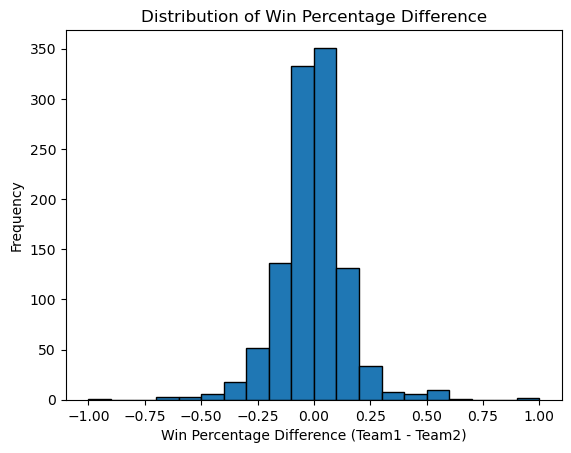

In [265]:
plt.hist(matches_df['win_pct_diff'], bins=20, edgecolor='black')
plt.xlabel('Win Percentage Difference (Team1 - Team2)')
plt.ylabel('Frequency')
plt.title('Distribution of Win Percentage Difference')
plt.show()

In [269]:
# Feature 2: Recent Form Difference
matches_df['recent_form_diff'] = 0.0
recent_matches = {}

for idx, row in tqdm(matches_df.iterrows(), total=len(matches_df)):
    team1, team2, date = row['team1'], row['team2'], row['date']
    
    # Calculate form for both teams
    def get_form(team, current_date):
        team_matches = matches_df[
            (matches_df['date'] < current_date) & 
            ((matches_df['team1'] == team) | (matches_df['team2'] == team))
        ].tail(5)
        
        if len(team_matches) == 0:
            return 0.5
        
        wins = (team_matches['winner'] == team).sum()
        return wins / len(team_matches)
    
    form_diff = get_form(team1, date) - get_form(team2, date)
    matches_df.at[idx, 'recent_form_diff'] = form_diff

100%|█████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:03<00:00, 332.44it/s]


In [271]:
# Print  few rows of the DataFrame with relevant columns
print(matches_df[['team1', 'team2', 'date', 'winner', 'recent_form_diff']].tail())

                            team1                  team2       date  \
1090                 Punjab Kings    Sunrisers Hyderabad 2024-05-19   
1091          Sunrisers Hyderabad  Kolkata Knight Riders 2024-05-21   
1092  Royal Challengers Bengaluru       Rajasthan Royals 2024-05-22   
1093          Sunrisers Hyderabad       Rajasthan Royals 2024-05-24   
1094          Sunrisers Hyderabad  Kolkata Knight Riders 2024-05-26   

                     winner  recent_form_diff  
1090    Sunrisers Hyderabad               0.2  
1091  Kolkata Knight Riders              -0.2  
1092       Rajasthan Royals               0.8  
1093    Sunrisers Hyderabad               0.4  
1094  Kolkata Knight Riders              -0.4  


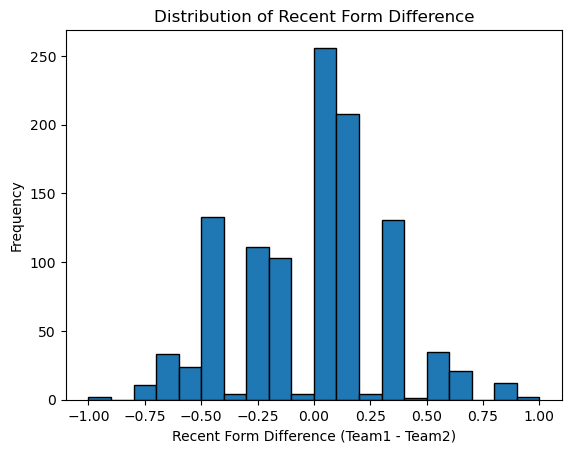

In [273]:
plt.hist(matches_df['recent_form_diff'], bins=20, edgecolor='black')
plt.xlabel('Recent Form Difference (Team1 - Team2)')
plt.ylabel('Frequency')
plt.title('Distribution of Recent Form Difference')
plt.show()

In [275]:
# Feature 3: Head-to-Head Advantage (Team1 perspective)
matches_df['h2h_advantage'] = 0.0

for idx, row in tqdm(matches_df.iterrows(), total=len(matches_df)):
    team1, team2, date = row['team1'], row['team2'], row['date']
    
    # Historical matches between these teams before current match date
    h2h = matches_df[
        (matches_df['date'] < date) & 
        (
            ((matches_df['team1'] == team1) & (matches_df['team2'] == team2)) |
            ((matches_df['team1'] == team2) & (matches_df['team2'] == team1))
        )
    ]
    
    if len(h2h) > 0:
        team1_wins = (h2h['winner'] == team1).sum()
        matches_df.at[idx, 'h2h_advantage'] = team1_wins / len(h2h)

100%|█████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:02<00:00, 536.40it/s]


In [277]:
# Print  few rows of the DataFrame with relevant columns
print(matches_df[['team1', 'team2', 'date', 'winner', 'h2h_advantage']].tail())

                            team1                  team2       date  \
1090                 Punjab Kings    Sunrisers Hyderabad 2024-05-19   
1091          Sunrisers Hyderabad  Kolkata Knight Riders 2024-05-21   
1092  Royal Challengers Bengaluru       Rajasthan Royals 2024-05-22   
1093          Sunrisers Hyderabad       Rajasthan Royals 2024-05-24   
1094          Sunrisers Hyderabad  Kolkata Knight Riders 2024-05-26   

                     winner  h2h_advantage  
1090    Sunrisers Hyderabad       0.318182  
1091  Kolkata Knight Riders       0.346154  
1092       Rajasthan Royals       0.500000  
1093    Sunrisers Hyderabad       0.526316  
1094  Kolkata Knight Riders       0.333333  


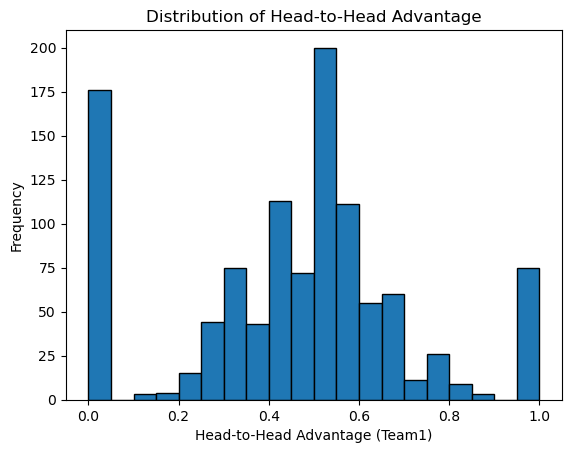

In [279]:
plt.hist(matches_df['h2h_advantage'], bins=20, edgecolor='black')
plt.xlabel('Head-to-Head Advantage (Team1)')
plt.ylabel('Frequency')
plt.title('Distribution of Head-to-Head Advantage')
plt.show()

In [281]:
# Precompute player career stats (batting + bowling)
def precompute_player_stats(deliveries_df):
    player_stats = {}
    
    # Batting stats
    batting = deliveries_df.groupby('batter').agg(
        total_runs=('batsman_runs', 'sum'),
        total_balls=('ball', 'count'),
        total_4s=('batsman_runs', lambda x: (x == 4).sum()),
        total_6s=('batsman_runs', lambda x: (x == 6).sum()),
        dismissals=('player_dismissed', lambda x: x.notnull().sum())
    ).reset_index()
    
    # Bowling stats
    bowling = deliveries_df.groupby('bowler').agg(
        total_wickets=('is_wicket', 'sum'),
        total_runs_conceded=('total_runs', 'sum'),
        total_balls_bowled=('ball', 'count')
    ).reset_index()
    
    # Merge batting and bowling stats
    combined = pd.merge(batting, bowling, left_on='batter', right_on='bowler', how='outer')
    combined['player'] = combined['batter'].combine_first(combined['bowler'])
    
    # Calculate derived metrics
    combined['batting_avg'] = combined['total_runs'] / combined['dismissals'].replace(0, np.nan)
    combined['strike_rate'] = combined['total_runs'] / combined['total_balls'] * 100
    combined['bowling_avg'] = combined['total_runs_conceded'] / combined['total_wickets'].replace(0, np.nan)
    combined['economy'] = combined['total_runs_conceded'] / (combined['total_balls_bowled'] / 6)
    
    return combined.set_index('player')

player_career_stats = precompute_player_stats(deliveries_df)

In [283]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare clustering features
cluster_features = player_career_stats[[
    'total_runs', 'strike_rate', 'total_wickets', 'economy'
]].fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# K-Means Clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
player_career_stats['cluster'] = kmeans.fit_predict(scaled_features)

# Interpret clusters (adjust based on your data)
cluster_labels = {
    0: 'Economical Bowlers',
    1: 'High Impact Batsmen',
    2: 'Consistent All-rounders'
}
player_career_stats['player_role'] = player_career_stats['cluster'].map(cluster_labels)

C:\Users\sagar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [285]:
def get_team_composition(team_players, player_stats):
    """Count player roles in a team"""
    roles = player_stats.loc[player_stats.index.isin(team_players), 'player_role']
    return roles.value_counts().reindex(cluster_labels.values(), fill_value=0)

# Feature engineering function
def create_advanced_features(matches, deliveries, player_stats):
    # Initialize new columns
    matches['batting_power'] = 0.0
    matches['bowling_strength'] = 0.0
    matches['all_rounder_impact'] = 0.0
    
    for idx, row in tqdm(matches.iterrows(), total=len(matches)):
        match_id = row['id']
        date = row['date']
        
        # Get players in match
        match_deliveries = deliveries[deliveries['match_id'] == match_id]
        team1_players = set(match_deliveries[match_deliveries['batting_team'] == row['team1']]['batter'])
        team2_players = set(match_deliveries[match_deliveries['batting_team'] == row['team2']]['batter'])
        
        # Get team compositions
        comp1 = get_team_composition(team1_players, player_stats)
        comp2 = get_team_composition(team2_players, player_stats)
        
        # Calculate differences
        matches.at[idx, 'batting_power'] = (
            comp1.get('High Impact Batsmen', 0) - 
            comp2.get('High Impact Batsmen', 0)
        )
        matches.at[idx, 'bowling_strength'] = (
            comp1.get('Economical Bowlers', 0) - 
            comp2.get('Economical Bowlers', 0)
        )
        matches.at[idx, 'all_rounder_impact'] = (
            comp1.get('Consistent All-rounders', 0) - 
            comp2.get('Consistent All-rounders', 0)
        )
        
        # Add venue win percentage (team1 perspective)
        venue = row['venue']
        team1_wins = matches[
            (matches['venue'] == venue) & 
            (matches['winner'] == row['team1']) &
            (matches['date'] < date)
        ].shape[0]
        
        team1_matches = matches[
            (matches['venue'] == venue) & 
            ((matches['team1'] == row['team1']) | 
             (matches['team2'] == row['team1'])) &
            (matches['date'] < date)
        ].shape[0]
        
        matches.at[idx, 'venue_win_pct'] = team1_wins / team1_matches if team1_matches > 0 else 0.5
        
        # Enhanced toss impact
        if row['toss_winner'] == row['team1']:
            matches.at[idx, 'toss_impact'] = 1 if row['toss_decision'] == 'field' else 0.5
        else:
            matches.at[idx, 'toss_impact'] = -1 if row['toss_decision'] == 'bat' else -0.5

    return matches

# Apply feature engineering
matches_df = create_advanced_features(matches_df, deliveries_df, player_career_stats)

100%|█████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:07<00:00, 146.31it/s]


In [287]:
# Shows the number of nulls in each column
print(matches_df.isnull().sum())


id                       0
season                   0
city                    51
date                     0
match_type               0
player_of_match          5
venue                    0
team1                    0
team2                    0
toss_winner              0
toss_decision            0
winner                   5
result                   0
result_margin           19
target_runs              3
target_overs             3
super_over               0
method                1074
umpire1                  0
umpire2                  0
win_pct_diff             0
recent_form_diff         0
h2h_advantage            0
batting_power            0
bowling_strength         0
all_rounder_impact       0
venue_win_pct            0
toss_impact              0
dtype: int64


In [289]:
# Drop rows where 'winner' is null
matches_df = matches_df.dropna(subset=['winner'])


In [291]:
print(matches_df['winner'].isnull().sum())  # Should print 0
print(matches_df.shape)  # Check new size


0
(1090, 28)


In [293]:
# dropping unnecessary  columns
matches_df.drop(columns=['super_over', 'city', 'venue', 'team2', 'result', 'target_overs', 'result_margin',  'target_runs', 'toss_winner', 'toss_decision', 'match_type', 'player_of_match', 'method', 'umpire1', 'umpire2'], inplace=True)


In [295]:
print(matches_df.shape)  # Check new size

(1090, 13)


In [297]:
matches_df.head()

,id,season,date,team1,winner,win_pct_diff,recent_form_diff,h2h_advantage,batting_power,bowling_strength,all_rounder_impact,venue_win_pct,toss_impact
0,335982,2008,2008-04-18,Royal Challengers Bengaluru,Kolkata Knight Riders,0.0,0.0,0.0,1.0,2.0,3.0,0.5,1.0
1,335983,2008,2008-04-19,Punjab Kings,Chennai Super Kings,0.0,0.0,0.0,-3.0,1.0,1.0,0.5,-1.0
2,335984,2008,2008-04-19,Delhi Capitals,Delhi Capitals,0.0,0.0,0.0,1.0,-5.0,-3.0,0.5,-1.0
3,335985,2008,2008-04-20,Mumbai Indians,Royal Challengers Bengaluru,0.5,0.5,0.0,-1.0,2.0,0.0,0.5,0.5
4,335986,2008,2008-04-20,Kolkata Knight Riders,Kolkata Knight Riders,0.5,0.5,0.0,0.0,-2.0,-1.0,0.5,-1.0


In [299]:
# Target variable
matches_df['target'] = (matches_df['winner'] == matches_df['team1']).astype(int)

# Final feature set
feature_columns = [
    'win_pct_diff',
    'recent_form_diff',
    'h2h_advantage',
    'venue_win_pct',          # New venue feature
    'toss_impact',            # Enhanced toss feature
    'batting_power',          # From clustering
    'bowling_strength',       # From clustering
    'all_rounder_impact'      # From clustering
]

X = matches_df[feature_columns]
y = matches_df['target']

In [301]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)  # Chronological split



In [303]:
# Inspect the first few rows of training data
print("First 5 rows of X_train:")
print(X_train.head())
print("\nFirst 5 rows of y_train:")
print(y_train.head())

First 5 rows of X_train:
   win_pct_diff  recent_form_diff  h2h_advantage  venue_win_pct  toss_impact  \
0           0.0               0.0            0.0            0.5          1.0   
1           0.0               0.0            0.0            0.5         -1.0   
2           0.0               0.0            0.0            0.5         -1.0   
3           0.5               0.5            0.0            0.5          0.5   
4           0.5               0.5            0.0            0.5         -1.0   

   batting_power  bowling_strength  all_rounder_impact  
0            1.0               2.0                 3.0  
1           -3.0               1.0                 1.0  
2            1.0              -5.0                -3.0  
3           -1.0               2.0                 0.0  
4            0.0              -2.0                -1.0  

First 5 rows of y_train:
0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int32


In [305]:
print("\nMissing values in X_train:")
print(X_train.isna().sum())
print("\nMissing values in y_train:")
print(y_train.isna().sum())


Missing values in X_train:
win_pct_diff          0
recent_form_diff      0
h2h_advantage         0
venue_win_pct         0
toss_impact           0
batting_power         0
bowling_strength      0
all_rounder_impact    0
dtype: int64

Missing values in y_train:
0


In [309]:
# Train XGBoost model with regularization
model = XGBClassifier(
    reg_alpha=0.5,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    max_depth=3,     # Simpler trees
    learning_rate=0.05,
    n_estimators=300,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Calculate model accuracy (test accuracy)
model_accuracy = model.score(X_test, y_test)

# Make predictions for additional metrics
y_pred = model.predict(X_test)

# Print model accuracy
print(f"Model Accuracy: {model_accuracy:.4f}")

# Additional evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Model Accuracy: 0.8303

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       106
           1       0.84      0.82      0.83       112

    accuracy                           0.83       218
   macro avg       0.83      0.83      0.83       218
weighted avg       0.83      0.83      0.83       218


Confusion Matrix:
[[89 17]
 [20 92]]


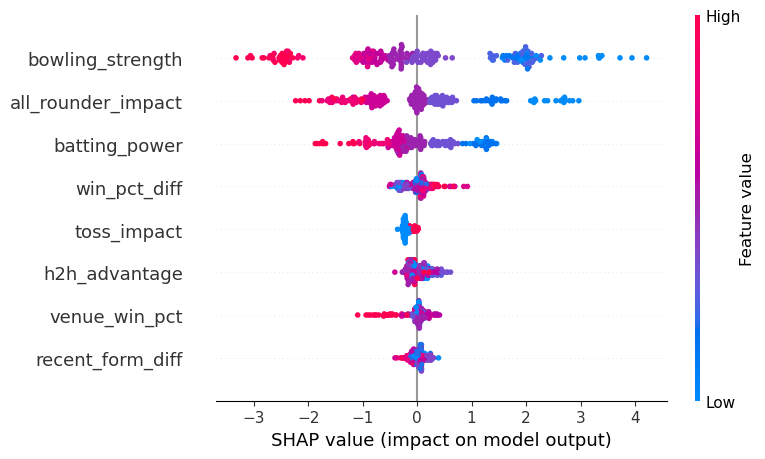

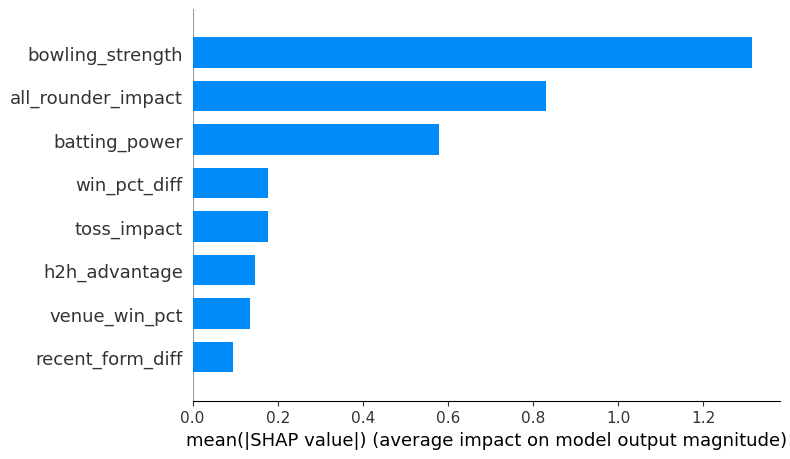

In [311]:
# SHAP analysis for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Generate SHAP bar plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

# Optional: Display the plot (if running in a local environment)
plt.show()

In [313]:
#Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [314]:
# Show best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Calculate model accuracy (test accuracy)
model_accuracy = best_model.score(X_test, y_test)
print(f"\nModel Accuracy: {model_accuracy:.4f}")

# Detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Model Accuracy: 0.8028

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       106
           1       0.82      0.79      0.81       112

    accuracy                           0.80       218
   macro avg       0.80      0.80      0.80       218
weighted avg       0.80      0.80      0.80       218


Confusion Matrix:
[[86 20]
 [23 89]]


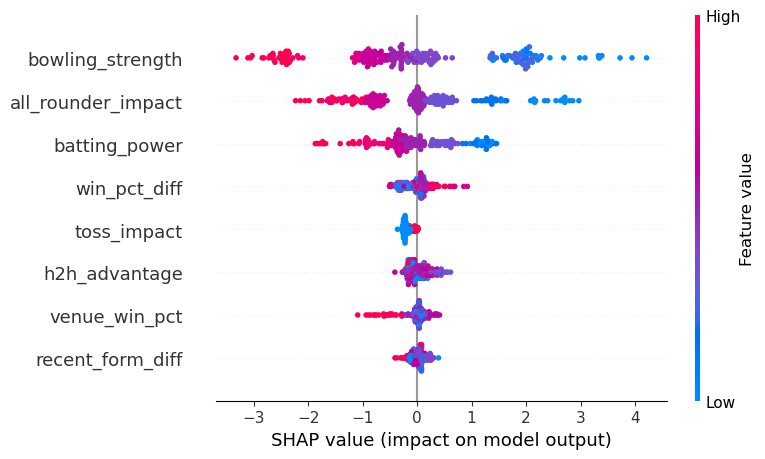

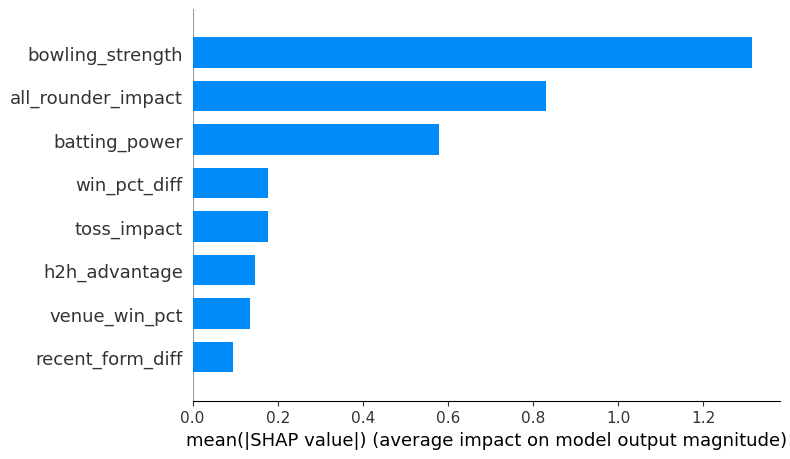

In [317]:
# SHAP analysis for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Generate SHAP bar plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

# Optional: Display the plot (if running in a local environment)
plt.show()

In [319]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from scipy.stats import randint, uniform
import shap
import matplotlib.pyplot as plt

# Step 1: Train-test split (chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Step 2: Define model and hyperparameter distribution
model = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

# Step 3: Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)



Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CD40BB5580>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CD55787B00>,
                                        'min_samples_leaf': <scipy.stats._distn_...CD55702000>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CD4871EC30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CD56599FD0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CD312D7F80>},
                   random_state=42, scoring='accuracy', verbose=2)

In [320]:
# Step 4: Evaluate best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

test_accuracy = best_model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)

print("\nBest Parameters:", random_search.best_params_)
print(f"Model Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Best Parameters: {'learning_rate': 0.09989013482764068, 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 161, 'subsample': 0.7975549966080241}
Model Accuracy: 0.7982
F1 Score: 0.7982

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       106
           1       0.82      0.78      0.80       112

    accuracy                           0.80       218
   macro avg       0.80      0.80      0.80       218
weighted avg       0.80      0.80      0.80       218

Confusion Matrix:
[[87 19]
 [25 87]]


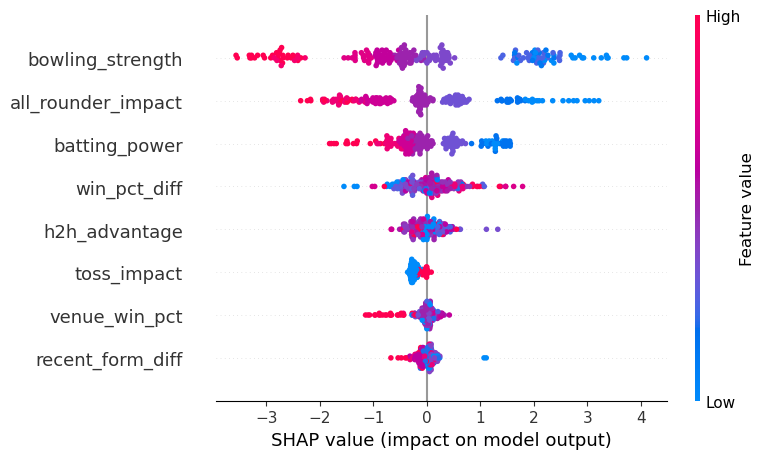

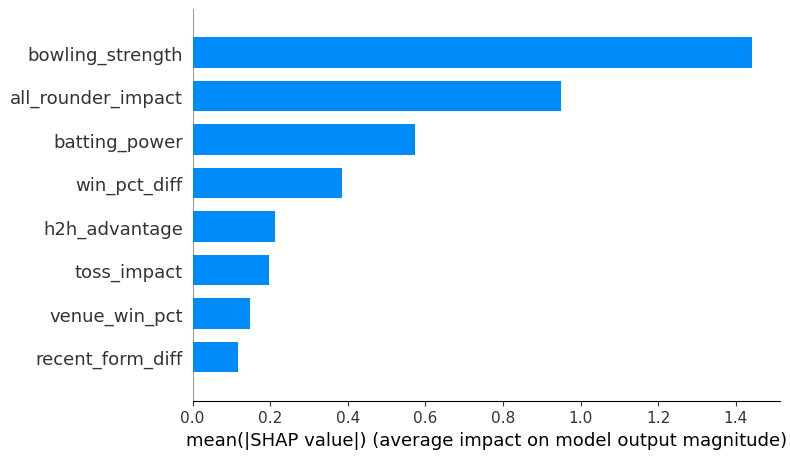

In [323]:
# Step 5: SHAP analysis
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# SHAP bar plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

plt.show()

In [378]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Chronological split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Initialize models with optimized parameters
models = [
    ('xgb', XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=300,
        random_state=42,
        eval_metric='logloss'
    )),
    ('lr', LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )),
    ('rf', RandomForestClassifier(
        max_depth=5,
        n_estimators=200,
        min_samples_split=10,
        random_state=42
    ))
]

# Create voting classifier with weights favoring your best performer (Logistic Regression)
voting_clf = VotingClassifier(
    estimators=models,
    voting='soft',
    weights=[1.0, 1.5, 1.0]  # Higher weight for LR
)

# Train and evaluate
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Voting Classifier Accuracy: {accuracy:.4f}")

Voting Classifier Accuracy: 0.8303
